# Medical Bill Extraction

Importing necessary libraries

In [414]:
import cv2 
from PIL import Image
import numpy as np
from pdf2image import convert_from_path
import pytesseract
from matplotlib import pyplot as plt
import re
import json

Converting the pages of the pdf into images 

In [415]:
# Store Pdf with convert_from_path function
images = convert_from_path('Sample_For_Assignment.pdf', poppler_path = r"C:\Program Files (x86)\Poppler\poppler-23.01.0\Library\bin")
 
for i in range(len(images)):
   
      # Save pages as images in the pdf
    images[i].save('page'+ str(i) +'.jpg', 'JPEG')

Reading images

In [416]:
images = convert_from_path('Sample_For_Assignment.pdf', poppler_path = r"C:\Program Files (x86)\Poppler\poppler-23.01.0\Library\bin")
len(images)
imgs_cv = []
for i in range(len(images)):
    imgs_cv.append(cv2.imread("page"+str(i)+".jpg",flags = cv2.IMREAD_GRAYSCALE))

imgs_cv[3]

array([[254, 254, 254, ..., 254, 254, 254],
       [254, 254, 254, ..., 254, 254, 254],
       [254, 254, 254, ..., 254, 254, 254],
       ...,
       [254, 254, 254, ..., 254, 254, 254],
       [249, 249, 249, ..., 249, 249, 249],
       [249, 249, 249, ..., 249, 249, 249]], dtype=uint8)

Histograms of Images

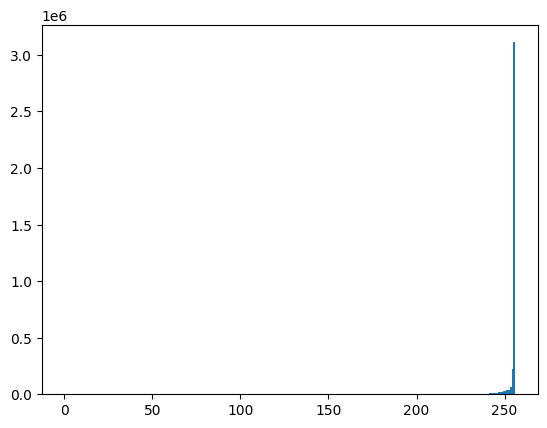

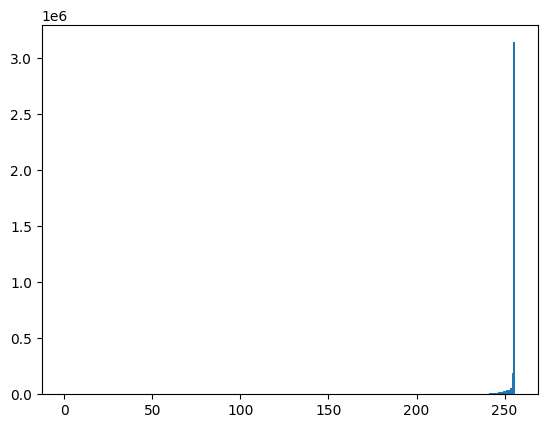

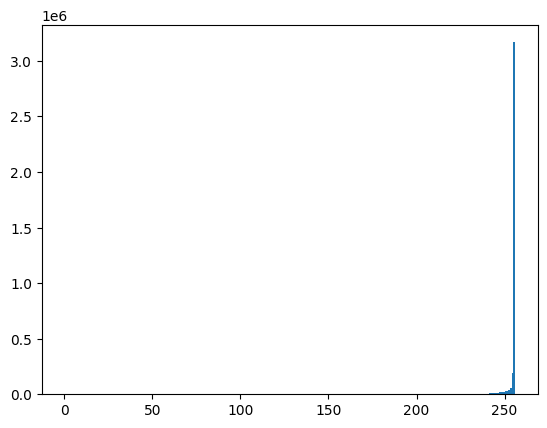

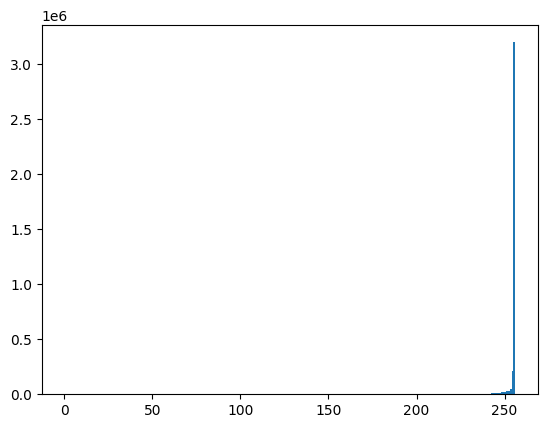

In [417]:
for x in imgs_cv:    
    plt.hist(x.ravel(),256,[0,256]); plt.show()

Image Processing of images

In [418]:
# Adding binary thresholding
def bin_thresholding(img):
    _,img_threshold = cv2.threshold(img,160,255,cv2.THRESH_BINARY)
    return img_threshold
   

Cropping image functions (To get some information accurately)

In [419]:
# in order to get some information it is better to crop the images along the verticle axis
def crop_to_half(image_to_crop):
    tbc_imHeight, tbc_imWidth = image_to_crop.shape
    cro_image = image_to_crop[0:int(tbc_imHeight), 0:int(tbc_imWidth/2)]
    return cro_image

In [420]:
def top_left_roi(image_to_crop):
    tbc_imHeight, tbc_imWidth = image_to_crop.shape
    cro_image = image_to_crop[0:int(tbc_imHeight/8.06), 0:int(tbc_imWidth/3.8)]
    return cro_image

In [421]:
def seal_place(image_to_crop):
    tbc_imHeight, tbc_imWidth = image_to_crop.shape
    cro_image = image_to_crop[int(tbc_imHeight/1.34):int(tbc_imHeight), 0:int(tbc_imWidth)]
    return cro_image

In [422]:
def loc_place(image_to_crop):
    tbc_imHeight, tbc_imWidth = image_to_crop.shape
    cro_image = image_to_crop[0:684, 960:int(tbc_imWidth)]
    return cro_image

In [423]:
def line_items_crop(image_to_crop):
    tbc_imHeight, tbc_imWidth = image_to_crop.shape
    cro_image = image_to_crop[719:1664, 0:int(tbc_imWidth)]
    return cro_image

Detect Strings using Tesseract for the whole page and different reigons of interest

In [424]:
# Defining Tesseract Location
pytesseract.pytesseract.tesseract_cmd = 'E:\\Softwares\\Tesseract\\tesseract.exe'

In [425]:
def det_for_full(img):    
    text_whole = pytesseract.image_to_string(img, lang='eng')
    return text_whole

In [426]:
# Half image detections
def det_for_lefthalf(img):
    half_image = crop_to_half(img)
    cropped_image_text = pytesseract.image_to_string(half_image, lang='eng')
    return cropped_image_text

In [427]:
# Top left ROI for Hospital/Clinic Detection
def det_top_left(img):
    top_left_roiIM = top_left_roi(img)
    topleft_image_text = pytesseract.image_to_string(top_left_roiIM, lang='eng')
    return topleft_image_text

In [428]:
# Seal detect to get invoice date
def det_seal(img):    
    seal_roiIM = seal_place(img)
    _,seal_roiIM = cv2.threshold(seal_roiIM,220,255,cv2.THRESH_BINARY)
    seal_text = pytesseract.image_to_string(seal_roiIM, lang='eng')
    return seal_text

In [429]:
# location detect
def loc_detect(img):
    loc_roiIM = loc_place(img)
    loc_text = pytesseract.image_to_string(loc_roiIM, lang='eng')
    return loc_text

In [430]:
# Line items extract (Better to define a ROI to get information more accurately and efficiently)
def line_items_extract(img):
    line_roiIM = line_items_crop(img)
    _,line_roiIM = cv2.threshold(line_roiIM,160,255,cv2.THRESH_BINARY)
    line_text = pytesseract.image_to_string(line_roiIM, lang='eng')
    return line_text

In [431]:
# page number extract
def page_num_extract(img):    
    _,page_thrsh_bin = cv2.threshold(img,220,255,cv2.THRESH_BINARY)
    mor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    page_erosion = cv2.erode(page_thrsh_bin, mor_kernel, iterations=1)
    page_text = pytesseract.image_to_string(page_erosion, lang='eng')
    return page_text

Defining Regular Expressions to extract data

In [432]:
# Patients NRIC
def get_patientID(det_strs):    
    patternID1 = "NRIC.*"
    matchesID1 = re.findall(patternID1,det_strs) 
    if len(matchesID1):  
        patternID2 = ":.*"
        matchesID2 = re.findall(patternID2,matchesID1[0])
        if len(matchesID2):
            NRIC = matchesID2[0].replace(":","").strip()
            return NRIC
        else: 
            return "No NRIC Infomation is preset"
    else: 
        return "No NRIC Infomation is preset"
        

In [433]:
# Patient Name
def get_patientName(det_strs):  
    patternPN1 = "(Patient|PATIENT).*"
    matchesPN1 = re.findall(patternPN1,det_strs) 
    if len(matchesPN1):  
        patternPN2 = ":.*"
        matchesPN2 = re.findall(patternPN2,matchesPN1[0])
        if len(matchesPN2):
            PN = matchesPN2[0].replace(":","").strip()
            return PN
        else: 
            return "No Patient Name Infomation is present"
            
    else: 
        return "No Patient Name Infomation is present"
         
# print(PN)

In [434]:
# Hospital / Clinic Name

def get_HospitalName(det_strs):  
    pattern1 = ".*Hospital"
    matches1 = re.findall(pattern1,det_strs,re.DOTALL | re.IGNORECASE)
    
    if len(matches1):  
        pattern2 = "[a-zA-Z\s]+"
        matches2 = re.findall(pattern2,matches1[0])
        if len(matches2):
            PN = re.sub('\\nIf','',matches2[0])
            PN = PN.replace("Hospital","").strip()
            return PN
        else: 
            return "No Patient Name Infomation is present"
            
    else: 
        return "No Patient Name Infomation is present"
        

In [435]:
def get_GST(det_strs):  
    pattern1 = "GST\s+REg\s+NO.*"
    matches1 = re.findall(pattern1,det_strs,re.IGNORECASE)
    
    if len(matches1):  
        pattern2 = "\S*\d+\S*"
        matches2 = re.findall(pattern2,matches1[0])
        if len(matches2):
            return matches2[0]
        else: 
            return "No GST Infomation is present"
            
    else: 
        return "No GST Infomation is present"
        

In [436]:
def get_Visit_date(det_strs):  
    pattern1 = "visit date.*"
    matches1 = re.findall(pattern1,det_strs,re.IGNORECASE)
    
    if len(matches1):  
        pattern2 = "\d\d.\d\d.\d\d\d\d"
        matches2 = re.findall(pattern2,matches1[0])
        if len(matches2):
            return matches2[0]
        else: 
            return "No Visit Date Infomation is present"
            
    else: 
        return "No Visit Date is present"
        

In [437]:
def get_Invoice_date(det_strs):  
    pattern1 = "invoice date.*"
    matches1 = re.findall(pattern1,det_strs,re.IGNORECASE)
    
    if len(matches1):  
        pattern2 = "\d\d.\d\d.\d\d\d\d"
        matches2 = re.findall(pattern2,matches1[0])
        if len(matches2):
            return matches2[0]
        else: 
            return "No Visit Date Infomation is present"
            
    else: 
        return "No Visit Date is present"
        

In [438]:
def get_bill_date(det_strs):
    pattern1 = "\d\s*\d\s+\w+\s+\d{4}"
    matches1 = re.findall(pattern1,det_strs)
    if len(matches1):
        return matches1[0]
    else: 
        return "No Visit Date Infomation is present"
         

In [439]:
# Tax Invoice Number

def Tax_Invoice_number(det_strs):  
    pattern1 = "Tax\sinvoice\sNumber.*"
    matches1 = re.findall(pattern1,det_strs,re.IGNORECASE)
    
    if len(matches1):  
        pattern2 = r"\b:\s*\d+\S*"
        matches2 = re.findall(pattern2,matches1[0])
        if len(matches2):
            TIN = re.sub(':','',matches2[0]).strip()
            return TIN
        else: 
            return "No Patient Name Infomation is present"
            
    else: 
        return "No Patient Name Infomation is present"
        

In [440]:
# Bill Reference Number

def Bill_reference_number(det_strs):  
    pattern1 = "Bill\s*ref.*"
    matches1 = re.findall(pattern1,det_strs,re.IGNORECASE)

    patternA = "Case\s+n.*"
    matchesA = re.findall(patternA,det_strs,re.IGNORECASE)
    
    if len(matches1):  
        pattern2 = ":\s*\d+\S*"
        matches2 = re.findall(pattern2,matches1[0])
        if len(matches2):
            TIN = re.sub(':','',matches2[0]).strip()
            return TIN
        else: 
            print("No Patient Name Infomation is present")
            return 0
    elif len(matchesA): 
        patternB = ":\s*.*"
        matchesB = re.findall(patternB,matchesA[0])
        if len(matchesB):
            TIN = re.sub(':','',matchesB[0]).strip()
            return TIN
        else: 
            return "No Patient Name Infomation is present"
            
    else:
        return "No Patient Name Infomation is present"
        

In [441]:
# Net amount payable
def Net_amount_payable(det_strs):  
    pattern1 = "net\s+amount\s+payable.*|total\s+amount\s+payable\s+\d+.*"
    matches1 = re.findall(pattern1,det_strs,re.IGNORECASE)
    
    if len(matches1):  
        pattern2 = r"\d+.*"
        matches2 = re.findall(pattern2,matches1[0])
        if len(matches2):
            return matches2[0]
        else: 
            return "No Patient Name Infomation is present"
            
    else: 
        return "No Patient Name Infomation is present"
         

In [442]:
def get_location(det_strs):
    pattern1 = "location\s+:.*"
    matches1 = re.findall(pattern1,det_strs,re.IGNORECASE)
    
    patternA = "Bill\s+location\s+:.*"
    matchesA = re.findall(patternA,det_strs,re.IGNORECASE | re.DOTALL)

    if len(matchesA):
        patternB = r"\b[A-Z]{2,}\b"
        matchesB = re.findall(patternB,matchesA[0],re.DOTALL)
        matchesB = matchesB[:-1]
        return " / ".join(matchesB)
        
    elif len(matches1):  
        pattern2 = r":\w+"
        matches2 = re.findall(pattern2,matches1[0])
        if len(matches2):
            return re.sub(':','',matches2[0]).strip()
            
        else: 
            return "No  Infomation is present"
             
    else: 
        return "No  Infomation is present"
        

In [443]:
def get_page_number(det_strs):
    pattern1 = "page\s+\d?\d"
    matches1 = re.findall(pattern1,det_strs,re.IGNORECASE)
    if len(matches1):
        return re.sub('Page','',matches1[0]).strip()
    else: 
        return "No info is present"

In [444]:
def get_bill_type(det_strs):
    pattern1 = "original"
    matches1 = re.findall(pattern1,det_strs,re.IGNORECASE)
    if len(matches1):
        return matches1[0]
    else: 
        return "No info is present"
        

Line item extraction

In [445]:
def get_linetext_dict(img):
    det_text = line_items_extract(bin_thresholding(img))    

    # Preprocess of detected text to remove unwanted items
    listA = det_text.split("\n")
    listB = []
    case_no = True
    if len([re.findall("DESCRIPTION",x) for x in listA][0]) != 0:
        case_no = False
        listB = [x for x in listA if x.count(' ') >= 3]
        [listB.remove(x) for x in listB if 'Subtotal' in x]
        [listB.remove(x) for x in listB if 'DESCRIPTION' in x]
        
    else:
        listB = [x for x in listA if len(re.findall("\d+",x)) != 0]
        # [listB.remove(x) for x in listB if 'Amount' in x]
        # [listB.remove(x) for x in listB if 'AMOUNT' in x]
        [listB.remove(x) for x in listB if 'PAYMENT:' in x]
        [listB.remove(x) for x in listB if 'contact' in x]

    # Creating line text dictionaries to each and every item     
    Table1 = []
    for i in range(len(listB)):
        if case_no:
            Table1.append({
                "Description" : " ".join([x.split()[0:-1] for x in listB][i]),
                "Quantity" : "No info present",
                "Amount" : [x.split()[-1] for x in listB][i],
                "Code" : "No info present",
                "Date" : "No info present",     
            })
        else:
            Table1.append({
                "Description" : " ".join([x.split()[1:-2] for x in listB][i]),
                "Quantity" : [x.split()[-2] for x in listB][i],
                "Amount" : [x.split()[-1] for x in listB][i],
                "Code" : [x.split()[0] for x in listB][i],
                "Date" : "No info present",     
            })
    return Table1

In [446]:
def get_keys_dict(img):    
    Key_values = {
        "Patient Name" : get_patientName(det_for_lefthalf(bin_thresholding(img))),
        "Patient National ID" : get_patientID(det_for_full(bin_thresholding(img))),
        "Hospital / clinic" : get_HospitalName(det_top_left(img)),
        "GST Reg No" : get_GST(det_for_full(bin_thresholding(img))),
        "Visit Date" : get_Visit_date(det_for_full(bin_thresholding(img))),
        "Tax Invoice Date" : get_Invoice_date(det_for_full(bin_thresholding(img))),
        "Bill /receipt date" : get_bill_date(det_seal(bin_thresholding(img))),
        "Tax invoice numbe" : Tax_Invoice_number(det_for_full(bin_thresholding(img))),
        "Bill reference number" : Bill_reference_number(det_for_full(bin_thresholding(img))),
        "Total Amount Payable" : Net_amount_payable(det_for_full(bin_thresholding(img))),
        "Location" : get_location(loc_detect(bin_thresholding(img))),
        "Page Number" : get_page_number(page_num_extract(bin_thresholding(img))),
        "Bill Type" : get_bill_type(det_for_full(bin_thresholding(img)))
    }
    return Key_values

In [449]:
def get_final_json(imgs):
    final_list = []
    for i,x in enumerate(imgs):
        final_list.append({
            "Page_Number": i+1,
            "Table" : get_linetext_dict(x),
            "Key_Values" : get_keys_dict(x)
        })
    
    final_dict_json = json.dumps(final_list)
    return final_dict_json, final_list

Getting the results of the pdf

In [450]:
json_out, list_out = get_final_json(imgs_cv)
print(f"The json string: {json_out}")
print(f"The dictionary string: {list_out}")

No Patient Name Infomation is present
The json string: [{"Page_Number": 1, "Table": [{"Description": "HLA DQB TYPING (PCR INT TO HIGH RES)", "Quantity": "1", "Amount": "243.93", "Code": "HLA03074", "Date": "No info present"}, {"Description": "HANDLING FEE 1", "Quantity": "18", "Amount": "00", "Code": "HF703102", "Date": "No info present"}, {"Description": "HLA ABCDR TYPING (SBT) FOR LOCAL TRANSPLANT", "Quantity": "1", "Amount": "885.98", "Code": "HLA09027", "Date": "No info present"}, {"Description": "HANDLING FEE", "Quantity": "1", "Amount": "18,00", "Code": "HF703102", "Date": "No info present"}, {"Description": "CREATININE CLEARANCE TEST (CCT)", "Quantity": "1", "Amount": "24,90", "Code": "10909606", "Date": "No info present"}, {"Description": "GLUCOSE-6-PHOSPHATE OEHYDROGENAS,", "Quantity": "4", "Amount": "23.30", "Code": "10010709", "Date": "No info present"}, {"Description": "GLUCOSE-8-PHOSPHATE DEHYDROGENAS", "Quantity": "1", "Amount": "23,30", "Code": "40010709", "Date": "No in

In [451]:
list_out

[{'Page_Number': 1,
  'Table': [{'Description': 'HLA DQB TYPING (PCR INT TO HIGH RES)',
    'Quantity': '1',
    'Amount': '243.93',
    'Code': 'HLA03074',
    'Date': 'No info present'},
   {'Description': 'HANDLING FEE 1',
    'Quantity': '18',
    'Amount': '00',
    'Code': 'HF703102',
    'Date': 'No info present'},
   {'Description': 'HLA ABCDR TYPING (SBT) FOR LOCAL TRANSPLANT',
    'Quantity': '1',
    'Amount': '885.98',
    'Code': 'HLA09027',
    'Date': 'No info present'},
   {'Description': 'HANDLING FEE',
    'Quantity': '1',
    'Amount': '18,00',
    'Code': 'HF703102',
    'Date': 'No info present'},
   {'Description': 'CREATININE CLEARANCE TEST (CCT)',
    'Quantity': '1',
    'Amount': '24,90',
    'Code': '10909606',
    'Date': 'No info present'},
   {'Description': 'GLUCOSE-6-PHOSPHATE OEHYDROGENAS,',
    'Quantity': '4',
    'Amount': '23.30',
    'Code': '10010709',
    'Date': 'No info present'},
   {'Description': 'GLUCOSE-8-PHOSPHATE DEHYDROGENAS',
    'Quan